In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cvxpy as cp
import gurobipy

from src.problem import Problem
from src.coco import CoCo
from pytorch.models import FFNet

np.random.seed(12)

In [2]:
dh_s = 120*60
initial_storage_MW = 0.0
max_storage_MW = 100e3

n_files = 5
n_sources = 12
max_sources = 8

N = 12
Ts = []
for ii in range(0,288, int(288/N)):
    Ts.append(ii)
Ts = np.atleast_2d(Ts).T

In [3]:
x_train = np.reshape(np.repeat(Ts, (n_files), axis=1).T, (n_files*N,1))
supply_train = np.zeros((n_sources, n_files*N))
demand_train = np.zeros(n_files*N)

for ii in range(n_files):
    str_ii = str(ii+1).zfill(2)
    supply_df = pd.read_csv('data/CAISO-supply-2021{}20.csv'.format(str_ii))
    demand_df = pd.read_csv('data/CAISO-demand-2021{}20.csv'.format(str_ii))
    renewables_df = pd.read_csv('data/CAISO-renewables-2021{}20.csv'.format(str_ii))

    natural_gas = supply_df.iloc[1].values[1:-1][Ts]
    large_hydro = supply_df.iloc[2].values[1:-1][Ts]
    imports = supply_df.iloc[3].values[1:-1][Ts]
    batteries = supply_df.iloc[4].values[1:-1][Ts]
    nuclear = supply_df.iloc[5].values[1:-1][Ts]
    coal = supply_df.iloc[6].values[1:-1][Ts]
#     other = supply_df.iloc[7].values[1:-1][Ts]

    solar = renewables_df.iloc[0].values[1:][Ts]
    wind = renewables_df.iloc[1].values[1:][Ts]
    geothermal = renewables_df.iloc[2].values[1:][Ts]
    biomass = renewables_df.iloc[3].values[1:][Ts]
    biogas = renewables_df.iloc[4].values[1:][Ts]
    small_hydro = renewables_df.iloc[5].values[1:][Ts]

    hour_ahead_forecast = demand_df.iloc[1].values[1:-1][Ts]

    idx_range = range(N*ii, N*(ii+1))
    supply_train[0, idx_range] = solar.flatten()
    supply_train[1, idx_range] = wind.flatten()
    supply_train[2, idx_range] = wind.flatten()
    supply_train[3, idx_range] = biomass.flatten()
    supply_train[4, idx_range] = biogas.flatten()
    supply_train[5, idx_range] = small_hydro.flatten()
    supply_train[6, idx_range] = natural_gas.flatten()
    supply_train[7, idx_range] = large_hydro.flatten()
    supply_train[8, idx_range] = imports.flatten()
    supply_train[9, idx_range] = batteries.flatten()
    supply_train[10, idx_range] = nuclear.flatten()
    supply_train[11, idx_range] = coal.flatten()

    demand_train[idx_range] = hour_ahead_forecast.flatten()

### Construct GPs for energy sources

In [4]:
supply_gps = []
εs = 1e3*np.ones(n_sources)

εs = [1e3, 1e3, 1e3, 1e1, 1e1, 3e1, 1e3, 1e3, 1e3, 1e2, 1e2, 5]

from src.gp import GaussianProcess
for ii in range(n_sources):
    gp = GaussianProcess()
    gp.train(x_train, supply_train[ii,:])
    gp.predict(Ts, ε=εs[ii])
    supply_gps.append(gp)

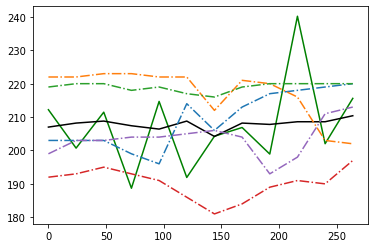

In [5]:
kk = 4
gp = supply_gps[kk]
plt.plot(Ts, gp.sample(), linestyle='-', color='g')
plt.plot(Ts, gp.mean, linestyle='-', color='k')
for ii in range(n_files):
    idx_range = range(N*ii,N*(ii+1))
    plt.plot(Ts, supply_train[kk,idx_range], linestyle='-.')

### Construct GP for demand

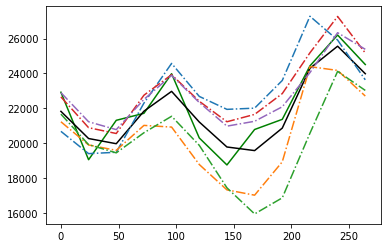

In [6]:
demand_gp = GaussianProcess()
demand_gp.train(x_train, demand_train)
demand_gp.predict(Ts, ε=1e3)

plt.plot(Ts, demand_gp.sample(), linestyle='-', color='g')
plt.plot(Ts, demand_gp.mean, linestyle='-', color='k')
for ii in range(n_files):
    idx_range = range(N*ii,N*(ii+1))
    plt.plot(Ts, demand_train[idx_range], linestyle='-.')

### Solve sample problem

In [7]:
supply = np.zeros((n_sources, N))
for ii, gp in enumerate(supply_gps):
    supply[ii] = gp.sample()
supply = np.maximum(supply, 0.0)

hour_ahead_forecast = demand_gp.sample()

In [8]:
params = {}
params['initial_storage_MW'] = initial_storage_MW
params['max_sources'] = max_sources
params['supply'] = supply
params['hour_ahead_forecast'] = hour_ahead_forecast

prob_features = []
for kk in params:
    prob_features.append(kk)

In [9]:
prob = Problem(N, n_sources)

In [10]:
prob_success, cost, solve_time, optvals = prob.solve_bin_problem(params)
print(cost)
print(solve_time)

Academic license - for non-commercial use only - expires 2021-07-20
Using license file /Users/acauligi/gurobi.lic
360032.04698803875
0.0315699577331543


In [11]:
y_opt = np.round(optvals[0])
prob.solve_coco_problem(params, y_opt)

(True, 360032.04698803875, 0.0315699577331543)

### Generate training dataset

In [12]:
num_probs = 100
prob = Problem(N, n_sources)

params = {}
for kk in prob.bin_prob_params:
    params[kk] = []
Y = np.zeros((num_probs, prob.n_sources, prob.N))
costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

prob_ii = 0
max_iter = np.floor(1.5*num_probs)
while prob_ii < num_probs:
    supply = np.zeros((n_sources, N))
    for ii, gp in enumerate(supply_gps):
        supply[ii] = gp.sample()
    supply = np.maximum(supply, 0.0)

    hour_ahead_forecast = demand_gp.sample()

    prob_params = {}
    prob_params['initial_storage_MW'] = initial_storage_MW
    prob_params['max_sources'] = max_sources
    prob_params['supply'] = supply
    prob_params['hour_ahead_forecast'] = hour_ahead_forecast

    prob_success, cost, solve_time, optvals = prob.solve_bin_problem(prob_params)

    if prob_success:
        y_opt = optvals[0]
        costs[prob_ii] = cost
        solve_times[prob_ii] = solve_time
        Y[prob_ii] = y_opt
        for kk in prob_params:
            params[kk].append(prob_params[kk])
        prob_ii += 1

/Users/acauligi/Dropbox/2020_21/spring_21/energy_291/energy291/lib/python3.7/site-packages/cvxpy/problems/problem.py:1268: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


### Train CoCo

In [13]:
system = "energy"
coco = CoCo(system, prob, prob_features)

In [14]:
train_data = [params, Y]

n_features = 1 + 1 + prob.n_sources*prob.N + prob.N
coco.construct_strategies(n_features, train_data)

coco.setup_network(device_id=-1)
coco.n_strategies

100

In [15]:
coco.training_params['TRAINING_ITERATIONS'] = 50
coco.train(verbose=False)

Saved model at /Users/acauligi/Dropbox/2020_21/spring_21/energy_291/project/energy291-project/CoCo_energy_20210601_2059.pt
Done training


### Evaluate CoCo

In [16]:
n_test = 100

n_succ = 0
count = 0

costs_coco = []
total_time_coco = []
num_solves_coco = []

cost_ratios_coco = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    supply = np.zeros((n_sources, N))
    for ii, gp in enumerate(supply_gps):
        supply[ii] = gp.sample()
    supply = np.maximum(supply, 0.0)
    hour_ahead_forecast = demand_gp.sample()

    prob_params = {}
    prob_params['initial_storage_MW'] = initial_storage_MW
    prob_params['max_sources'] = max_sources
    prob_params['supply'] = supply
    prob_params['hour_ahead_forecast'] = hour_ahead_forecast

    try:
        prob_success, true_cost, ip_solve_time, optvals = prob.solve_bin_problem(prob_params)
        if not prob_success:
            continue

        prob_success, cost, total_time, n_evals = coco.forward(prob_params, solver=cp.GUROBI)

        count += 1
        if prob_success:
            n_succ += 1
            costs_coco += [cost]
            total_time_coco += [total_time]
            num_solves_coco += [n_evals]

            costs_ip += [true_cost]
            total_time_ip += [ip_solve_time]

            cost_ratios_coco += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_coco = np.array(costs_coco)
cost_ratios_coco = np.array(cost_ratios_coco)
total_time_coco = np.array(total_time_coco)
num_solves_coco = np.array(num_solves_coco, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

coco_percentage = 100 * float(n_succ) / float(count)
coco_percentage

100.0

In [ ]:
supply = np.zeros((n_sources, N))
for ii, gp in enumerate(supply_gps):
    supply[ii] = gp.sample()
supply = np.maximum(supply, 0.0)
hour_ahead_forecast = demand_gp.sample()

prob_params = {}
prob_params['initial_storage_MW'] = initial_storage_MW
prob_params['max_sources'] = max_sources
prob_params['supply'] = supply
prob_params['hour_ahead_forecast'] = hour_ahead_forecast

In [ ]:
fast_times = []
for _ in range(20):
    supply = np.zeros((n_sources, N))
    for ii, gp in enumerate(supply_gps):
        supply[ii] = gp.sample()
    supply = np.maximum(supply, 0.0)
    hour_ahead_forecast = demand_gp.sample()

    prob_params = {}
    prob_params['initial_storage_MW'] = initial_storage_MW
    prob_params['max_sources'] = max_sources
    prob_params['supply'] = supply
    prob_params['hour_ahead_forecast'] = hour_ahead_forecast

    times = []
    for _ in range(100):
        prob_success, true_cost, ip_solve_time, optvals = prob.solve_bin_problem(prob_params)
        if not prob_success:
            continue
        times.append(ip_solve_time)
    fast_times.append(np.mean(times))

In [ ]:
times = []
for _ in range(100):
    prob_success, true_cost, ip_solve_time, optvals = prob.solve_bin_problem(prob_params)
    times.append(ip_solve_time)
np.mean(times)

In [ ]:
prob_params = {}
prob_params['initial_storage_MW'] = initial_storage_MW
prob_params['max_sources'] = max_sources
prob_params['supply'] = supply
prob_params['hour_ahead_forecast'] = hour_ahead_forecast

prob_success, true_cost, ip_solve_time, optvals = prob.solve_bin_problem(prob_params)